In [17]:
import pandas as pd
import numpy as np
import requests
import pandahouse as ph
import seaborn as sns
from urllib.parse import urlencode
import matplotlib.pyplot as plt

Создадим основной и дополнительный датасеты для проверки работы функций.

Начнём с создания основного датасета

In [18]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key1 = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ' 
 
final_url = base_url + urlencode(dict(public_key=public_key1)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 

download_response = requests.get(download_url) 
groups = pd.read_csv(download_url, sep=';')

In [19]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key1 = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ' 
 
final_url = base_url + urlencode(dict(public_key=public_key1)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 

download_response = requests.get(download_url) 
customers = pd.read_csv(download_url, sep=',')

In [20]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key1 = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA' 
 
final_url = base_url + urlencode(dict(public_key=public_key1)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 

download_response = requests.get(download_url) 
checks = pd.read_csv(download_url, sep=';')

In [21]:
groups.rename(columns={'id': 'student_id'}, inplace=True)
customers_info = groups.merge(checks, on='student_id', how='left')
customers_info.fillna(0, inplace=True)
customers_info.rev = customers_info.rev.astype(int)
customers_list = customers.student_id.to_list()
customers_info['purchase'] = customers_info.rev.apply(lambda x: True if x != 0 else False)
customers_info['is_active'] = customers_info.student_id.apply(lambda x: True if x in customers_list else False)
customers_info.drop(customers_info.query('is_active == False & purchase == True').index, inplace=True)

In [22]:
customers_info.head(5)

,student_id,grp,rev,purchase,is_active
0,1489,B,0,False,False
1,1627,A,990,True,True
2,1768,B,0,False,False
3,1783,B,0,False,False
4,1794,A,0,False,False


Теперь загрузим дополнительный датасет (в дальнейшем можно заменить на путь или ссылку)

In [23]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key1 = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ' 
 
final_url = base_url + urlencode(dict(public_key=public_key1)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 

download_response = requests.get(download_url) 
groups_add = pd.read_csv(download_url, sep=',')

Создание функции для перерасчёта метрик после добавления новых данных

In [29]:
def add_data(main_database, groups_add):
    try:
        newdata_add = groups_add.rename(columns={'id': 'student_id'})
        newdata_add = newdata_add.merge(checks, on='student_id', how='left')
        newdata_add.fillna(0, inplace=True)
        newdata_add.rev = newdata_add.rev.astype(int)
        newdata_add['purchase'] = newdata_add.rev.apply(lambda x: True if x != 0 else False)
        newdata_add['is_active'] = newdata_add.student_id.apply(lambda x: True if x in customers_list else False)
        global updated_database
        updated_database = pd.concat([main_database, newdata_add], axis=0)
        target_group = updated_database[(updated_database.grp == 'B') & (updated_database.is_active)]
        control_group = updated_database[(updated_database.grp == 'A') & (updated_database.is_active)]
        
        CR_control = control_group[control_group.purchase].student_id.nunique()/control_group.student_id.nunique()
        CR_target = target_group[target_group.purchase].student_id.nunique()/target_group.student_id.nunique()

        ARPPU_control = control_group.rev.sum()/control_group[control_group.purchase].student_id.nunique()
        ARPPU_target = target_group.rev.sum()/target_group[target_group.purchase].student_id.nunique()

        ARPU_control = round(CR_control * ARPPU_control, 2)
        ARPU_target = round(CR_target * ARPPU_target, 2)
        print(f'''
Конверсия в покупку у контрольной группы составляет: {round(CR_control, 3)}
Средняя выручка на покупающего пользователя из контрольной группы составляет: {round(ARPPU_control, 2)}
Средняя выручка на пользователя из контрольной группы составляет: {ARPU_control}

Конверсия в покупку у целевой группы составляет: {round(CR_target, 3)} (изменение на {abs((round(CR_target/CR_control - 1, 2)))*100}%)
Средняя выручка на покупающего пользователя из целевой группы составляет: {round(ARPPU_target, 2)} (изменение на {round((ARPPU_target/ARPPU_control-1)*100, 2)}%)
Средняя выручка на пользователя из целевой группы составляет: {ARPU_target} (изменение на {round((ARPU_target/ARPU_control-1)*100, 2)}%)''')
    except:
        print('''Произошла ошибка при соединении таблиц.
Проверьте предоставляемые данные и попробуйте снова.''')


Проверка работоспособности функции по добавлению данных и обновлению метрик.

In [30]:
add_data(customers_info, groups_add)


Конверсия в покупку у контрольной группы составляет: 0.051
Средняя выручка на покупающего пользователя из контрольной группы составляет: 933.59
Средняя выручка на пользователя из контрольной группы составляет: 47.35

Конверсия в покупку у целевой группы составляет: 0.046 (изменение на 9.0%)
Средняя выручка на покупающего пользователя из целевой группы составляет: 1257.88 (изменение на 34.74%)
Средняя выручка на пользователя из целевой группы составляет: 58.06 (изменение на 22.62%)


Теперь создадим функцию по черчению графиков метрик из переданного датасета

In [38]:
def draw_graphs(database):
    target_group = database[(database.grp == 'B') & (database.is_active)]
    control_group = database[(database.grp == 'A') & (database.is_active)]
    
    CR_control = control_group[control_group.purchase].student_id.nunique()/control_group.student_id.nunique()
    CR_target = target_group[target_group.purchase].student_id.nunique()/target_group.student_id.nunique()
    CR_diff = pd.DataFrame({'grp': ['A', 'B'], 'CR_of_groups': [CR_control, CR_target]})

    ARPPU_control = control_group.rev.sum()/control_group[control_group.purchase].student_id.nunique()
    ARPPU_target = target_group.rev.sum()/target_group[target_group.purchase].student_id.nunique()
    ARPPU_diff = pd.DataFrame({'grp': ['A', 'B'], 'ARPPU_of_groups': [ARPPU_control, ARPPU_target]})

    ARPU_control = round(CR_control * ARPPU_control, 2)
    ARPU_target = round(CR_target * ARPPU_target, 2)
    ARPU_diff = pd.DataFrame({'grp': ['A', 'B'], 'ARPU_diff_of_groups': [ARPU_control, ARPU_target]})
    
    sns.set()
    
    fig, axes = plt.subplots(1, 3, sharey=True, figsize=(15,2))
    fig.suptitle('Метрики датасета')
    
    sns.barplot(ax=axes[0], x=CR_diff.CR_of_groups, y=CR_diff.grp)
    
    sns.barplot(ax=axes[1], x=ARPPU_diff.ARPPU_of_groups, y=ARPPU_diff.grp)
    
    sns.barplot(ax=axes[2], x=ARPU_diff.ARPU_diff_of_groups, y=ARPU_diff.grp)

Проверка работы функции по рисованию графиков

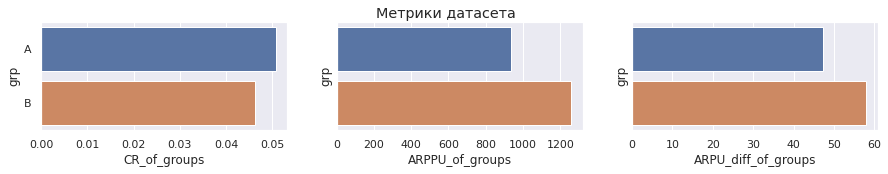

In [39]:
draw_graphs(updated_database)